In [18]:
# Import the AudioSegment class for processing audio and the 
# split_on_silence function for separating out silent chunks.
from pydub import AudioSegment 
from pydub.silence import split_on_silence
import numpy as np, matplotlib.pyplot as plot, librosa, librosa.display, sklearn
from sklearn.mixture import GaussianMixture as GMM
import sys

In [2]:
#normalize a chunk to a target amplitude.
def match_target_amplitude(aChunk, target_dBFS):
    ''' Normalize given audio chunk '''
    change_in_dBFS = target_dBFS - aChunk.dBFS
    return aChunk.apply_gain(change_in_dBFS)

#silence removal, normalization and trimming
def remove_silence(path):
    # Load your audio.
    song = AudioSegment.from_file(path)
    final_chunk=AudioSegment.empty()
    # Split track where the silence is 3 seconds or more and get chunks using 
    # the imported function.
    chunks = split_on_silence (
        # Use the loaded audio.
        song, 
        # Specify that a silent chunk must be at least 3 seconds or 3000 ms long.
        min_silence_len = 3000,
        # Consider a chunk silent if it's quieter than -16 dBFS.
        # (You may want to adjust this parameter.)
        silence_thresh = -30
    )
    
    # Process each chunk with your parameters
    for i, chunk in enumerate(chunks):

        # Normalize the entire chunk.
        normalized_chunk = match_target_amplitude(chunk, -20.0)

        #final chunk made by joining all non silent chunks
        final_chunk+=normalized_chunk
    
    # trimming the song, taking only 1 sec from beginning
    final_song = final_chunk[:3000]

    #convert the song into numpy array
    song_array = final_song.get_array_of_samples()
    song_array = np.array(song_array)
    return song_array

In [43]:
#extracting mfccs and scaling them
def scaled_mfccs(song_array):
    song_array = song_array.astype(float)
    mfccs = librosa.feature.mfcc(song_array)
    
    #scaling the MFCCs such that each coefficient dimension has zero mean and unit variance
    mfccs = sklearn.preprocessing.scale(mfccs,axis =1)
    return mfccs

In [44]:
#training dataset location text file
location = "/media/abhiroopd/New Volume/audio/"
#5 songs per singer, each has mfccs of size 20x130, we stack them vertically
features = np.empty([100, 130])
count = 1 
i = 0
with open("train.txt", "r") as training_file:
    for path in training_file:
        #remove leading and trailing spaces
        path = path.strip()
        song_array = remove_silence(location+path)
        mfccs = scaled_mfccs(song_array)
        
        
        if(count <= 5):
            features[i:i+20, :] = mfccs
            i = i+1
        if(count == 5):  
            np.set_printoptions(threshold=sys.maxsize)
            print(features)
            break
#             gmm =  GMM(n_components=3).fit(features)   
            count = 0
            i = 0
        count = count+1    

/home/abhiroopd/Documents/programs/singer_identification/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/abhiroopd/Documents/programs/singer_identification/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/abhiroopd/Documents/programs/singer_identification/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical 

[[ 1.36323059e+000  1.64080596e+000  1.39882112e+000  1.01735795e+000
   8.62560391e-001  8.18103731e-001  7.84035265e-001  7.06108391e-001
   5.51580310e-001  5.88139951e-001  8.08419764e-001  6.34483218e-001
  -3.42697114e-001 -1.51412153e+000 -3.47093552e-001  3.48006040e-001
   4.31469738e-001  2.89588898e-001  4.70544305e-003 -4.10076976e-001
  -4.82114971e-001 -2.59122789e-001  6.97036624e-001  1.19369209e+000
   1.15870285e+000  9.64169204e-001  8.68957222e-001  8.60217333e-001
   8.47542107e-001  6.80786014e-001  5.51388741e-001  6.10659599e-001
   6.28128469e-001  6.40197635e-001  5.07321537e-001  2.74542540e-001
   1.49337590e-001 -3.89253855e-001 -1.05090356e+000 -1.32577419e+000
   6.60693586e-001  1.42765975e+000  1.15951610e+000  9.21809494e-001
   8.02029192e-001  6.99616551e-001  6.29614711e-001  7.84359336e-001
   9.95226204e-001  1.01193011e+000  8.35265756e-001  4.90352690e-001
  -3.60371508e-002 -6.92981839e-001 -7.75911212e-001 -5.81179619e-001
  -4.95090842e-001 -

[-230878486 -265262423 -301946324 ...  236330698  214584613  191151598]


/home/abhiroopd/Documents/programs/singer_identification/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/abhiroopd/Documents/programs/singer_identification/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


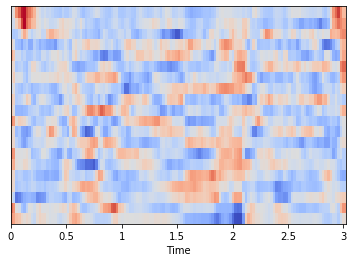

In [4]:
song_array = remove_silence('audio_files/test.m4a')
print(song_array)
mfccs = scaled_mfccs(song_array)
librosa.display.specshow(mfccs, x_axis='time')
plot.show()

In [48]:
features.shape
np.argwhere(np.isnan(features))

array([[50, 31]])